# PFA case, SF crime dataset

## Import libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns

## Load data

In [3]:
# Load the datasets
sf_data = pd.read_csv('C:/Users/harun/Desktop/PFAcase/sf_data.csv', sep=';')
sf_districts = pd.read_csv('C:/Users/harun/Desktop/PFAcase/sf_districts.csv', sep=';')

## Exploratory Data Analysis and Visualization

In [4]:
# Display the first few rows of sf_data
print("SF Data Head:")
sf_data.head()

SF Data Head:


id        category    description    weekday        date  \
0   5069701104134         assault        battery  wednesday  06/22/2005   
1   6074729204104         assault        assault   saturday  07/15/2006   
2   7103536315201         assault       stalking    tuesday  09/25/2007   
3  11082415274000  missing person  missing adult   saturday  09/24/2011   
4   4037801104134         assault        battery     friday  12/12/2003   

    time resolution   longitude   latitude    label  
0  12:20       none -122.428223  37.781896  violent  
1  00:55       none -122.410672  37.799789  violent  
2  00:01       none -122.458226  37.741362  violent  
3  11:00    located -122.459173  37.708200    other  
4  12:00       none -122.386667  37.789882  violent

In [5]:
# Display the first few rows of sf_districts
print("\nSF Districts Head:")
sf_districts.head()


SF Districts Head:


id   district
0  17074762928150  sunnydale
1  17020189127170  sunnydale
2  18007948463010  sunnydale
3  18001184015200  sunnydale
4  18028426362050  sunnydale

With these two datasets (sf_data & sf_districts), we can combine into one dataset by matching on the ID

In [6]:
# Combine the two dataset on ID to locate district
sf_combined = pd.merge(sf_data, sf_districts, on='id')

In [7]:
# see info and if there is null values
sf_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 592854 entries, 0 to 592853
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   id           592854 non-null  int64  
 1   category     592854 non-null  object 
 2   description  592854 non-null  object 
 3   weekday      592854 non-null  object 
 4   date         592854 non-null  object 
 5   time         592854 non-null  object 
 6   resolution   592854 non-null  object 
 7   longitude    592854 non-null  float64
 8   latitude     592854 non-null  float64
 9   label        592854 non-null  object 
 10  district     592854 non-null  object 
dtypes: float64(2), int64(1), object(8)
memory usage: 49.8+ MB


For each column, the non-null count is 592,854, which matches the total number of entries. This indicates that there are no null values in any of the columns.

In [8]:
# Display the first few rows of sf_combined
print("SF combined data Head:")
sf_combined.head()

SF combined data Head:


id       category                   description    weekday  \
0  18023216504170        assault            false imprisonment   saturday   
1  17067335371000   non-criminal                 lost property  wednesday   
2  17083623864020   non-criminal  aided case, mental disturbed     friday   
3  18029886606243  larceny/theft  petty theft from locked auto     sunday   
4  16624968706372  larceny/theft       petty theft of property     sunday   

         date   time resolution   longitude   latitude    label    district  
0  03/24/2018  07:00       none -122.419053  37.758632  violent     mission  
1  07/19/2017  12:00       none -122.419672  37.765050    other     mission  
2  10/13/2017  06:45       none -122.416894  37.784286    other  tenderloin  
3  04/22/2018  18:00       none -122.420691  37.781483    other  tenderloin  
4  08/21/2016  10:00       none -122.417885  37.785438    other  tenderloin

In [9]:
sf_combined.columns.values

array(['id', 'category', 'description', 'weekday', 'date', 'time',
       'resolution', 'longitude', 'latitude', 'label', 'district'],
      dtype=object)

In [10]:
# category count
sf_combined['category'].value_counts()

category
larceny/theft                  99205
other offenses                 93381
drug/narcotic                  71757
non-criminal                   61517
assault                        53665
warrants                       42460
vandalism                      21319
suspicious occ                 19734
vehicle theft                  18885
robbery                        18401
burglary                       15155
prostitution                   11590
fraud                           9319
missing person                  8951
weapon laws                     7032
trespass                        6634
secondary codes                 5681
forgery/counterfeiting          5073
disorderly conduct              4552
drunkenness                     3444
stolen property                 3247
sex offenses, forcible          2767
recovered vehicle               1671
liquor laws                     1576
kidnapping                      1314
driving under the influence     1213
loitering                    

Larceny/Theft has the most occurrences and there is imbalanced classes.

In [11]:
# how many categories
sf_combined['category'].nunique()

36

In [12]:
# district crime count
sf_combined['district'].value_counts()

district
tenderloin    345423
mission       234320
sunnydale      13111
Name: count, dtype: int64

In [13]:
# weekday count
sf_combined['weekday'].value_counts()

weekday
wednesday    89858
tuesday      87202
friday       86683
thursday     85661
saturday     83799
monday       82148
sunday       77503
Name: count, dtype: int64

In [14]:
# resolution count
sf_combined['resolution'].value_counts()

resolution
none                                      287284
arrest, booked                            224817
arrest, cited                              54693
psychopathic case                           9701
unfounded                                   5215
located                                     4348
complainant refuses to prosecute            1922
not prosecuted                              1560
district attorney refuses to prosecute      1541
prosecuted by outside agency                 885
exceptional clearance                        863
prosecuted for lesser offense                 25
Name: count, dtype: int64

In [15]:
# labels
sf_combined['label'].value_counts()

label
other           426402
intoxication     77990
violent          76872
prostitution     11590
Name: count, dtype: int64

In [16]:
sf_combined[['longitude','latitude']].describe()

longitude       latitude
count  592854.000000  592854.000000
mean     -122.414255      37.772778
std         0.005363       0.015436
min      -122.428723      37.708083
25%      -122.418730      37.762743
50%      -122.413989      37.781567
75%      -122.409708      37.784286
max      -122.404619      37.787847

Latitude and longitude coordinates are in San Fransisco, CA is: 37.773972, -122.431297. So the coordinates seems to be fine, since we don't have any anormalies.

###  What are the Most Common Crimes in San Francisco from 2013 to 2018?

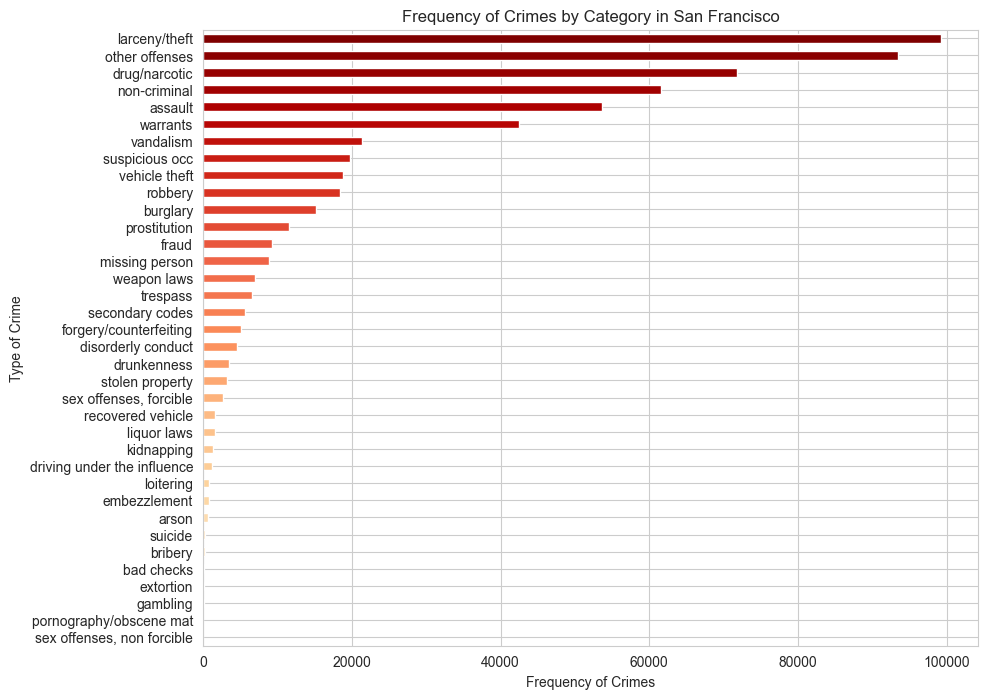

In [17]:
# Data preparation
crime_type_df = sf_combined['category'].value_counts(ascending=True)

# Set the Seaborn style
sns.set_style('whitegrid')

# Basic plotting with a color map
colors = plt.cm.OrRd(np.linspace(0, 1, len(crime_type_df)))
plt.figure(figsize=(10, 8))
crime_type_df.plot(kind='barh', color=colors)

# Adding title and labels
plt.title("Frequency of Crimes by Category in San Francisco")
plt.xlabel("Frequency of Crimes")
plt.ylabel("Type of Crime")
#plt.savefig('freq_of_crimes_category.png', bbox_inches='tight')

plt.show()

From the plot above, it was evident that larceny and theft lead as the most common crimes in San Francisco.

### Distribution of Crime by District

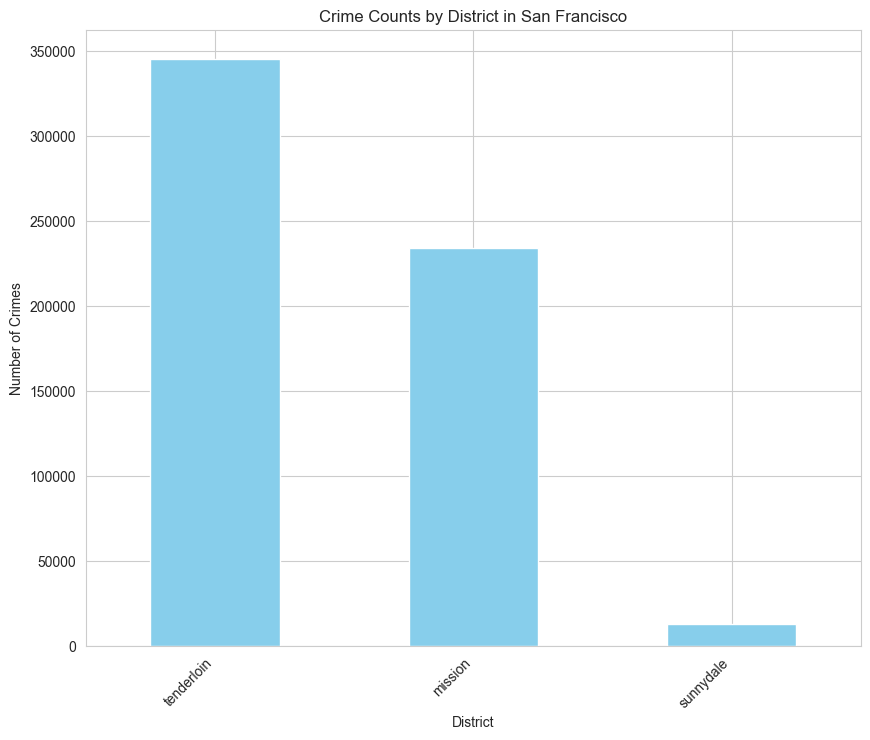

In [18]:
# Data preparation
district_counts = sf_combined['district'].value_counts()

# Set the Seaborn style
sns.set_style('whitegrid')

# Basic plotting
plt.figure(figsize=(10, 8))
district_counts.plot(kind='bar', color='skyblue')

# Adding title and labels
plt.title("Crime Counts by District in San Francisco")
plt.xlabel("District")
plt.ylabel("Number of Crimes")

# Adjust x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

#plt.savefig('district1.png', bbox_inches='tight')

plt.show()

It is expected for crimes not to be evenly distributed across different districts, especially taking into consideration that the area of these districts varies in shape and size. 

### Distribution of embezzlement crimes by District (as an example)

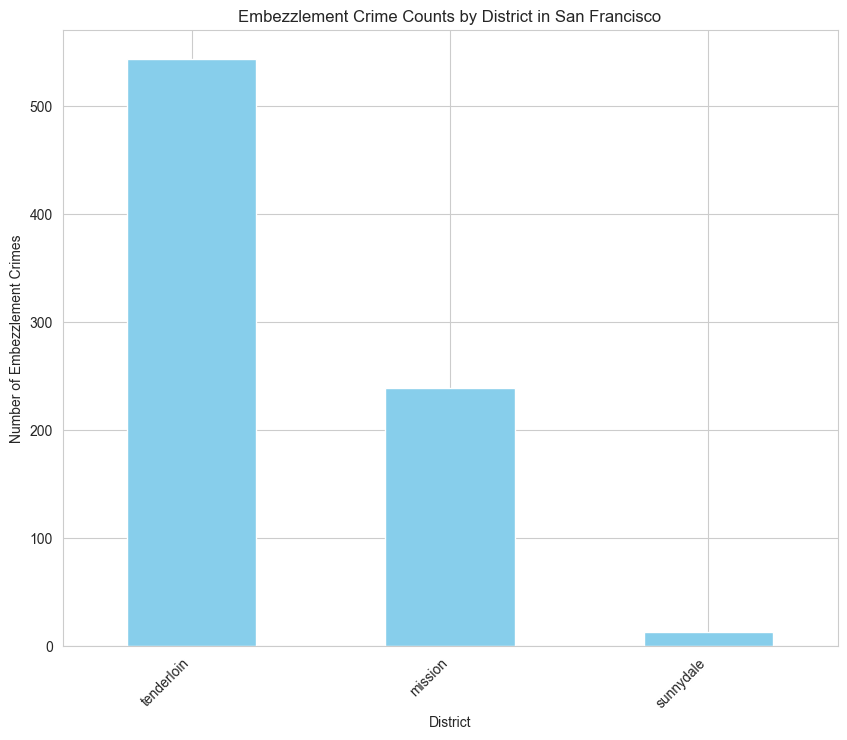

In [19]:
# Filter data for 'embezzlement' crimes as example
embezzlement_data = sf_combined[sf_combined['category'] == 'embezzlement']

# Count of 'embezzlement' crimes by district
embezzlement_district_counts = embezzlement_data['district'].value_counts()

# Set the Seaborn style
sns.set_style('whitegrid')

# Basic plotting
plt.figure(figsize=(10, 8))
embezzlement_district_counts.plot(kind='bar', color='skyblue')

# Adding title and labels
plt.title("Embezzlement Crime Counts by District in San Francisco")
plt.xlabel("District")
plt.ylabel("Number of Embezzlement Crimes")

# Adjust x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

plt.show()


### Distribution of Crime over 24 hours

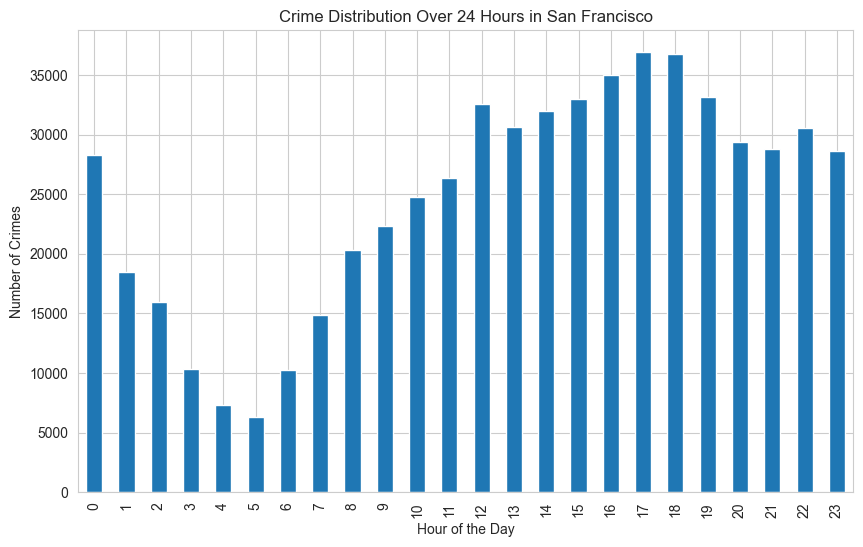

In [20]:
# Convert the 'time' column to just time data (feature)
sf_combined['time'] = pd.to_datetime(sf_combined['time'], format='%H:%M').dt.time

# Temporarily convert 'time' back to datetime to extract the hour
sf_combined['hour'] = pd.to_datetime(sf_combined['time'].astype(str), format='%H:%M:%S').dt.hour

# Group by hour and count the number of crimes
hourly_crime = sf_combined.groupby('hour').size()

# Set the Seaborn style
sns.set_style('whitegrid')

# Plot
plt.figure(figsize=(10, 6))
hourly_crime.plot(kind='bar')
plt.title('Crime Distribution Over 24 Hours in San Francisco')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Crimes')
plt.xticks(range(0, 24))

#plt.savefig('time1.png', bbox_inches='tight')


plt.show()


The hour of the day also plays an important role when trying to predict crime rates. At 4:00 to 5:00 have the lowest crime rates. As we increase the hour, the crime rates increase on average until we reach 17:00. After 18:00, crime rates tend to decrease until 4:00 am where the cycle repeats. 

### Temporal distribution of Crime Categories over 24 hours

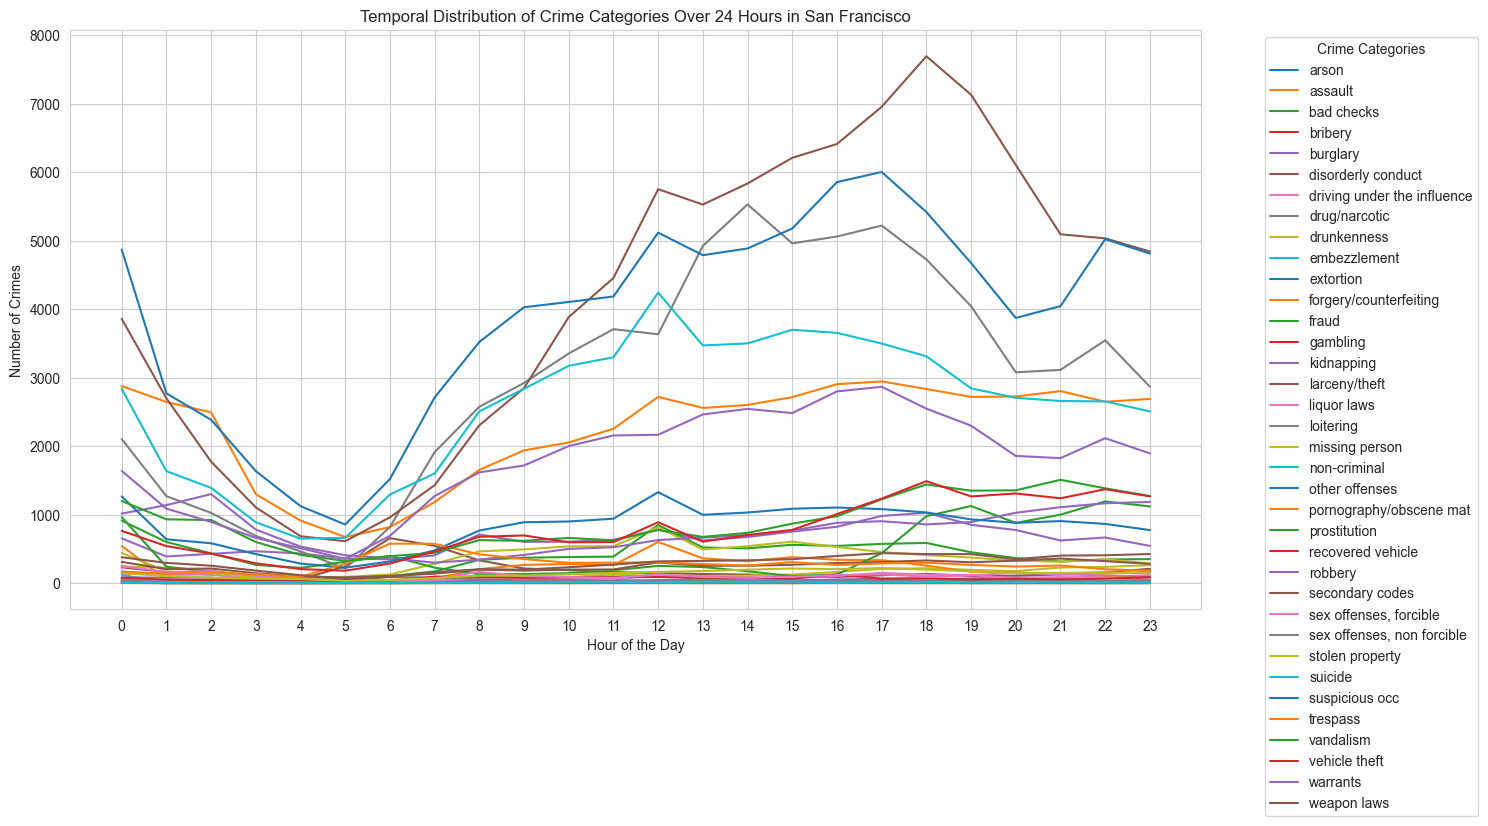

In [21]:
# Group by both category and hour, then count the number of crimes
category_hourly = sf_combined.groupby(['category', 'hour']).size().unstack(fill_value=0)

# Set the aesthetics for the plot
sns.set_style('whitegrid')
plt.figure(figsize=(15, 8))

# Plotting each category
for category in category_hourly.index:
    plt.plot(category_hourly.columns, category_hourly.loc[category], label=category)

plt.title('Temporal Distribution of Crime Categories Over 24 Hours in San Francisco')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Crimes')
plt.xticks(range(0, 24))
plt.legend(title='Crime Categories', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()


### Temporal distribution of Crime Categories over 24 hours (individual plots)

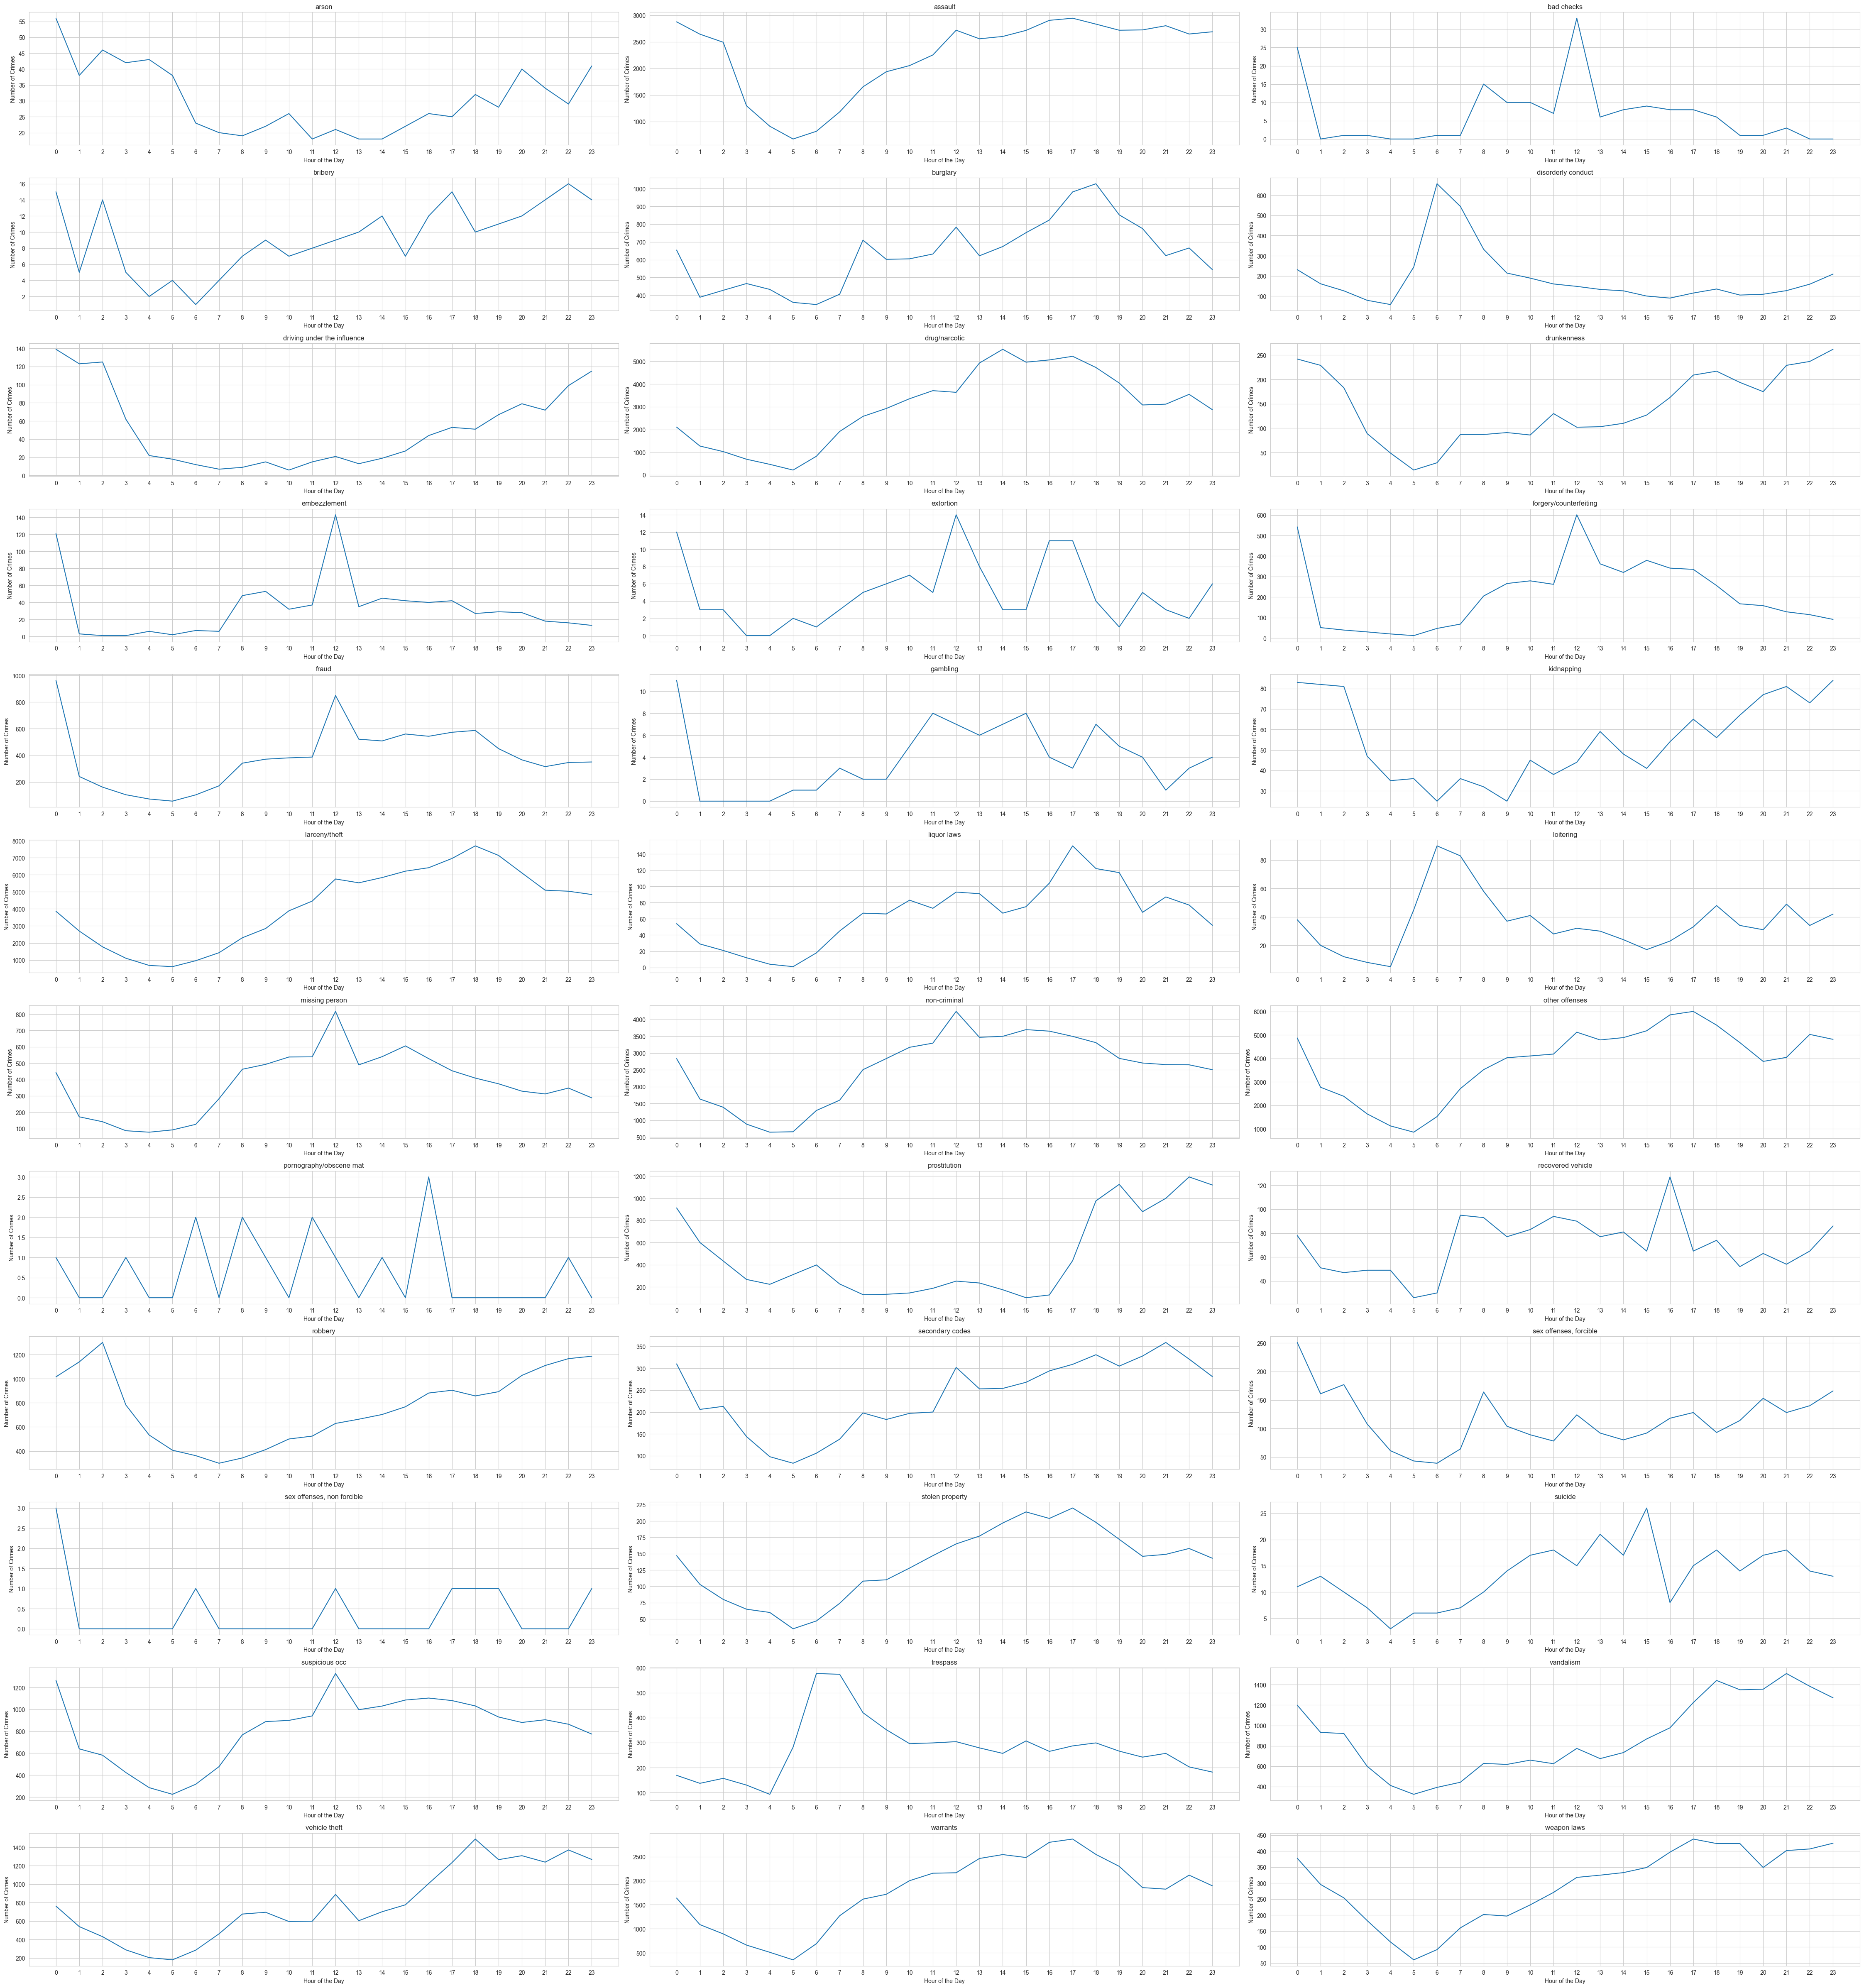

In [22]:
# Group by both category and hour, then count the number of crimes
category_hourly = sf_combined.groupby(['category', 'hour']).size().unstack(fill_value=0)

# Set the aesthetics for the plot
sns.set_style('whitegrid')

# Determine the number of categories
num_categories = len(category_hourly.index)

# Set the number of columns for the subplot grid
num_cols = 3  # Adjust this based on your preference and the number of categories
num_rows = np.ceil(num_categories / num_cols).astype(int)

# Create a subplot grid
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15 * num_cols, 4 * num_rows))

# Flatten the array of axes for easy iteration
axs = axs.flatten()

# Plotting each category in its own subplot
for i, category in enumerate(category_hourly.index):
    axs[i].plot(category_hourly.columns, category_hourly.loc[category], label=category)
    axs[i].set_title(category)
    axs[i].set_xlabel('Hour of the Day')
    axs[i].set_ylabel('Number of Crimes')
    axs[i].set_xticks(range(0, 24))

# Hide any unused subplots
for i in range(num_categories, len(axs)):
    axs[i].axis('off')

plt.tight_layout()

#plt.savefig('time2.png', bbox_inches='tight')


plt.show()


### Top 5 crimes over 24 hrs for better overview

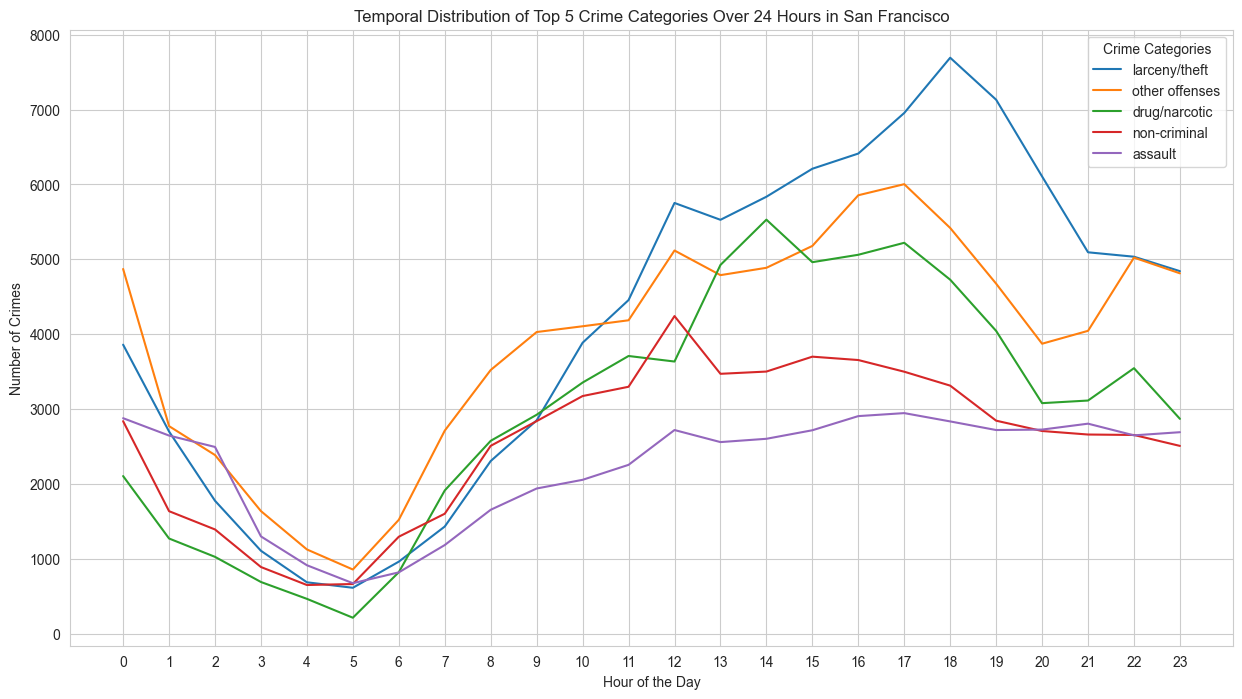

In [23]:
# Group by both category and hour, then count the number of crimes
category_hourly = sf_combined.groupby(['category', 'hour']).size().unstack(fill_value=0)

# Selecting top N categories for clarity
top_categories = category_hourly.sum(axis=1).nlargest(5).index
top_category_hourly = category_hourly.loc[top_categories]

# Set the aesthetics for the plot
sns.set_style('whitegrid')
plt.figure(figsize=(15, 8))

# Plotting each category
for category in top_category_hourly.index:
    plt.plot(top_category_hourly.columns, top_category_hourly.loc[category], label=category)

plt.title('Temporal Distribution of Top 5 Crime Categories Over 24 Hours in San Francisco')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Crimes')
plt.xticks(range(0, 24))
plt.legend(title='Crime Categories')

#plt.savefig('time3.png', bbox_inches='tight')

plt.show()

### Distribution of Crimes per weekday

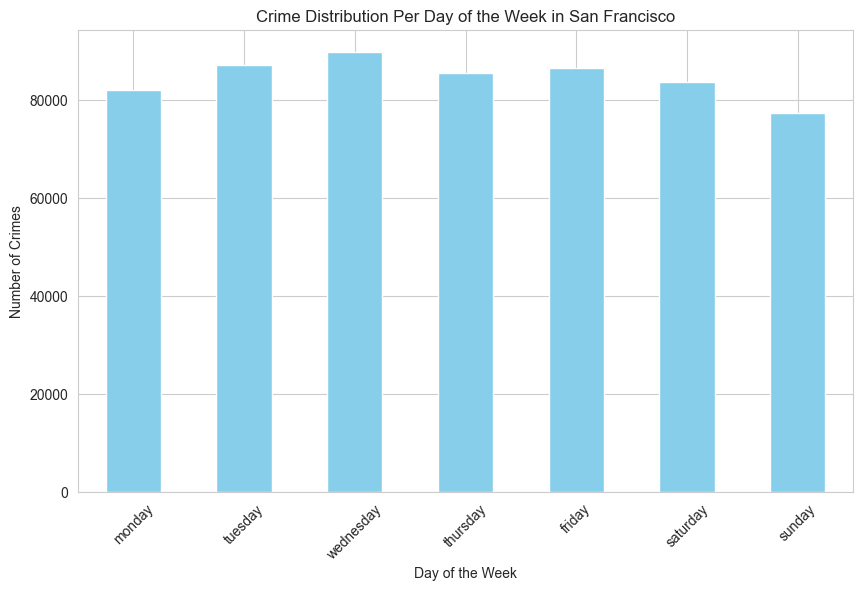

In [24]:
# Assuming your dataframe is named sf_combined
# Group by weekday and count the number of crimes
weekday_crime = sf_combined.groupby('weekday').size()

# Sorting the days in the correct order
order = ["monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday"]
weekday_crime = weekday_crime.reindex(order)

# Set the aesthetics for the plot
sns.set_style('whitegrid')
plt.figure(figsize=(10, 6))

# Plot
weekday_crime.plot(kind='bar', color='skyblue')
plt.title('Crime Distribution Per Day of the Week in San Francisco')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Crimes')
plt.xticks(rotation=45)


#plt.savefig('dag1.png', bbox_inches='tight')
plt.show()

# wednesday    89858
# tuesday      87202
# friday       86683
# thursday     85661
# saturday     83799
# monday       82148
# sunday       77503

Crimes rates vary between days of the week. Wednesday the day with most crimes committed on average while Sunday has the lowest crime rates of all days of the week.

### Temporal distribution of Crime Categories over weekdays

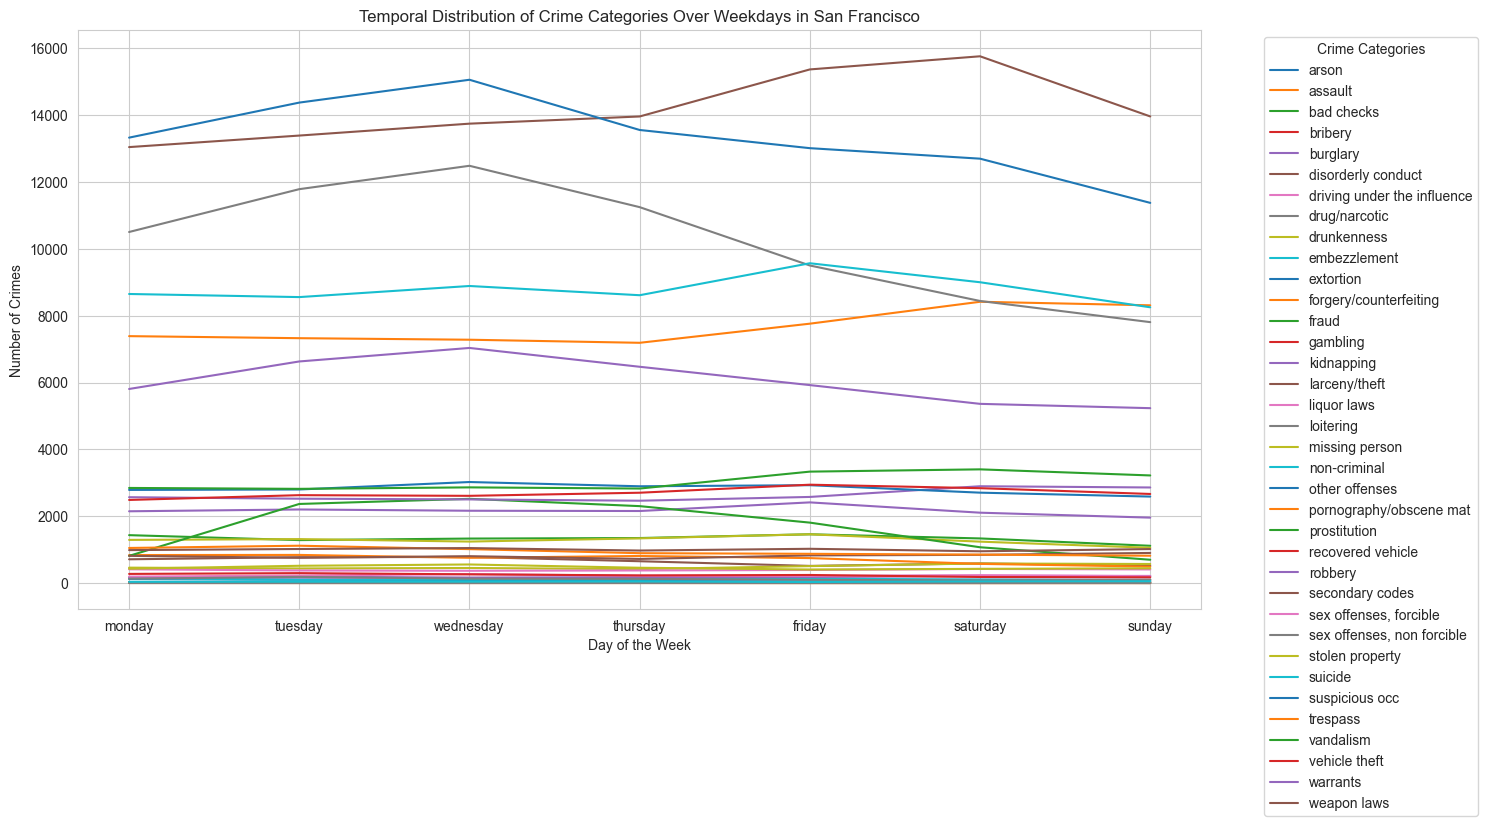

In [25]:
# Group by both category and weekday, then count the number of crimes
category_weekday = sf_combined.groupby(['category', 'weekday']).size().unstack(fill_value=0)

# Order the weekdays
category_weekday = category_weekday[order]

# Set the aesthetics for the plot
sns.set_style('whitegrid')
plt.figure(figsize=(15, 8))

# Plotting each category
for category in category_weekday.index:
    plt.plot(category_weekday.columns, category_weekday.loc[category], label=category)

plt.title('Temporal Distribution of Crime Categories Over Weekdays in San Francisco')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Crimes')
plt.xticks(range(0, 7), order)
plt.legend(title='Crime Categories', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()

### Temporal distribution of Crime Categories over weekdays (individual plots)

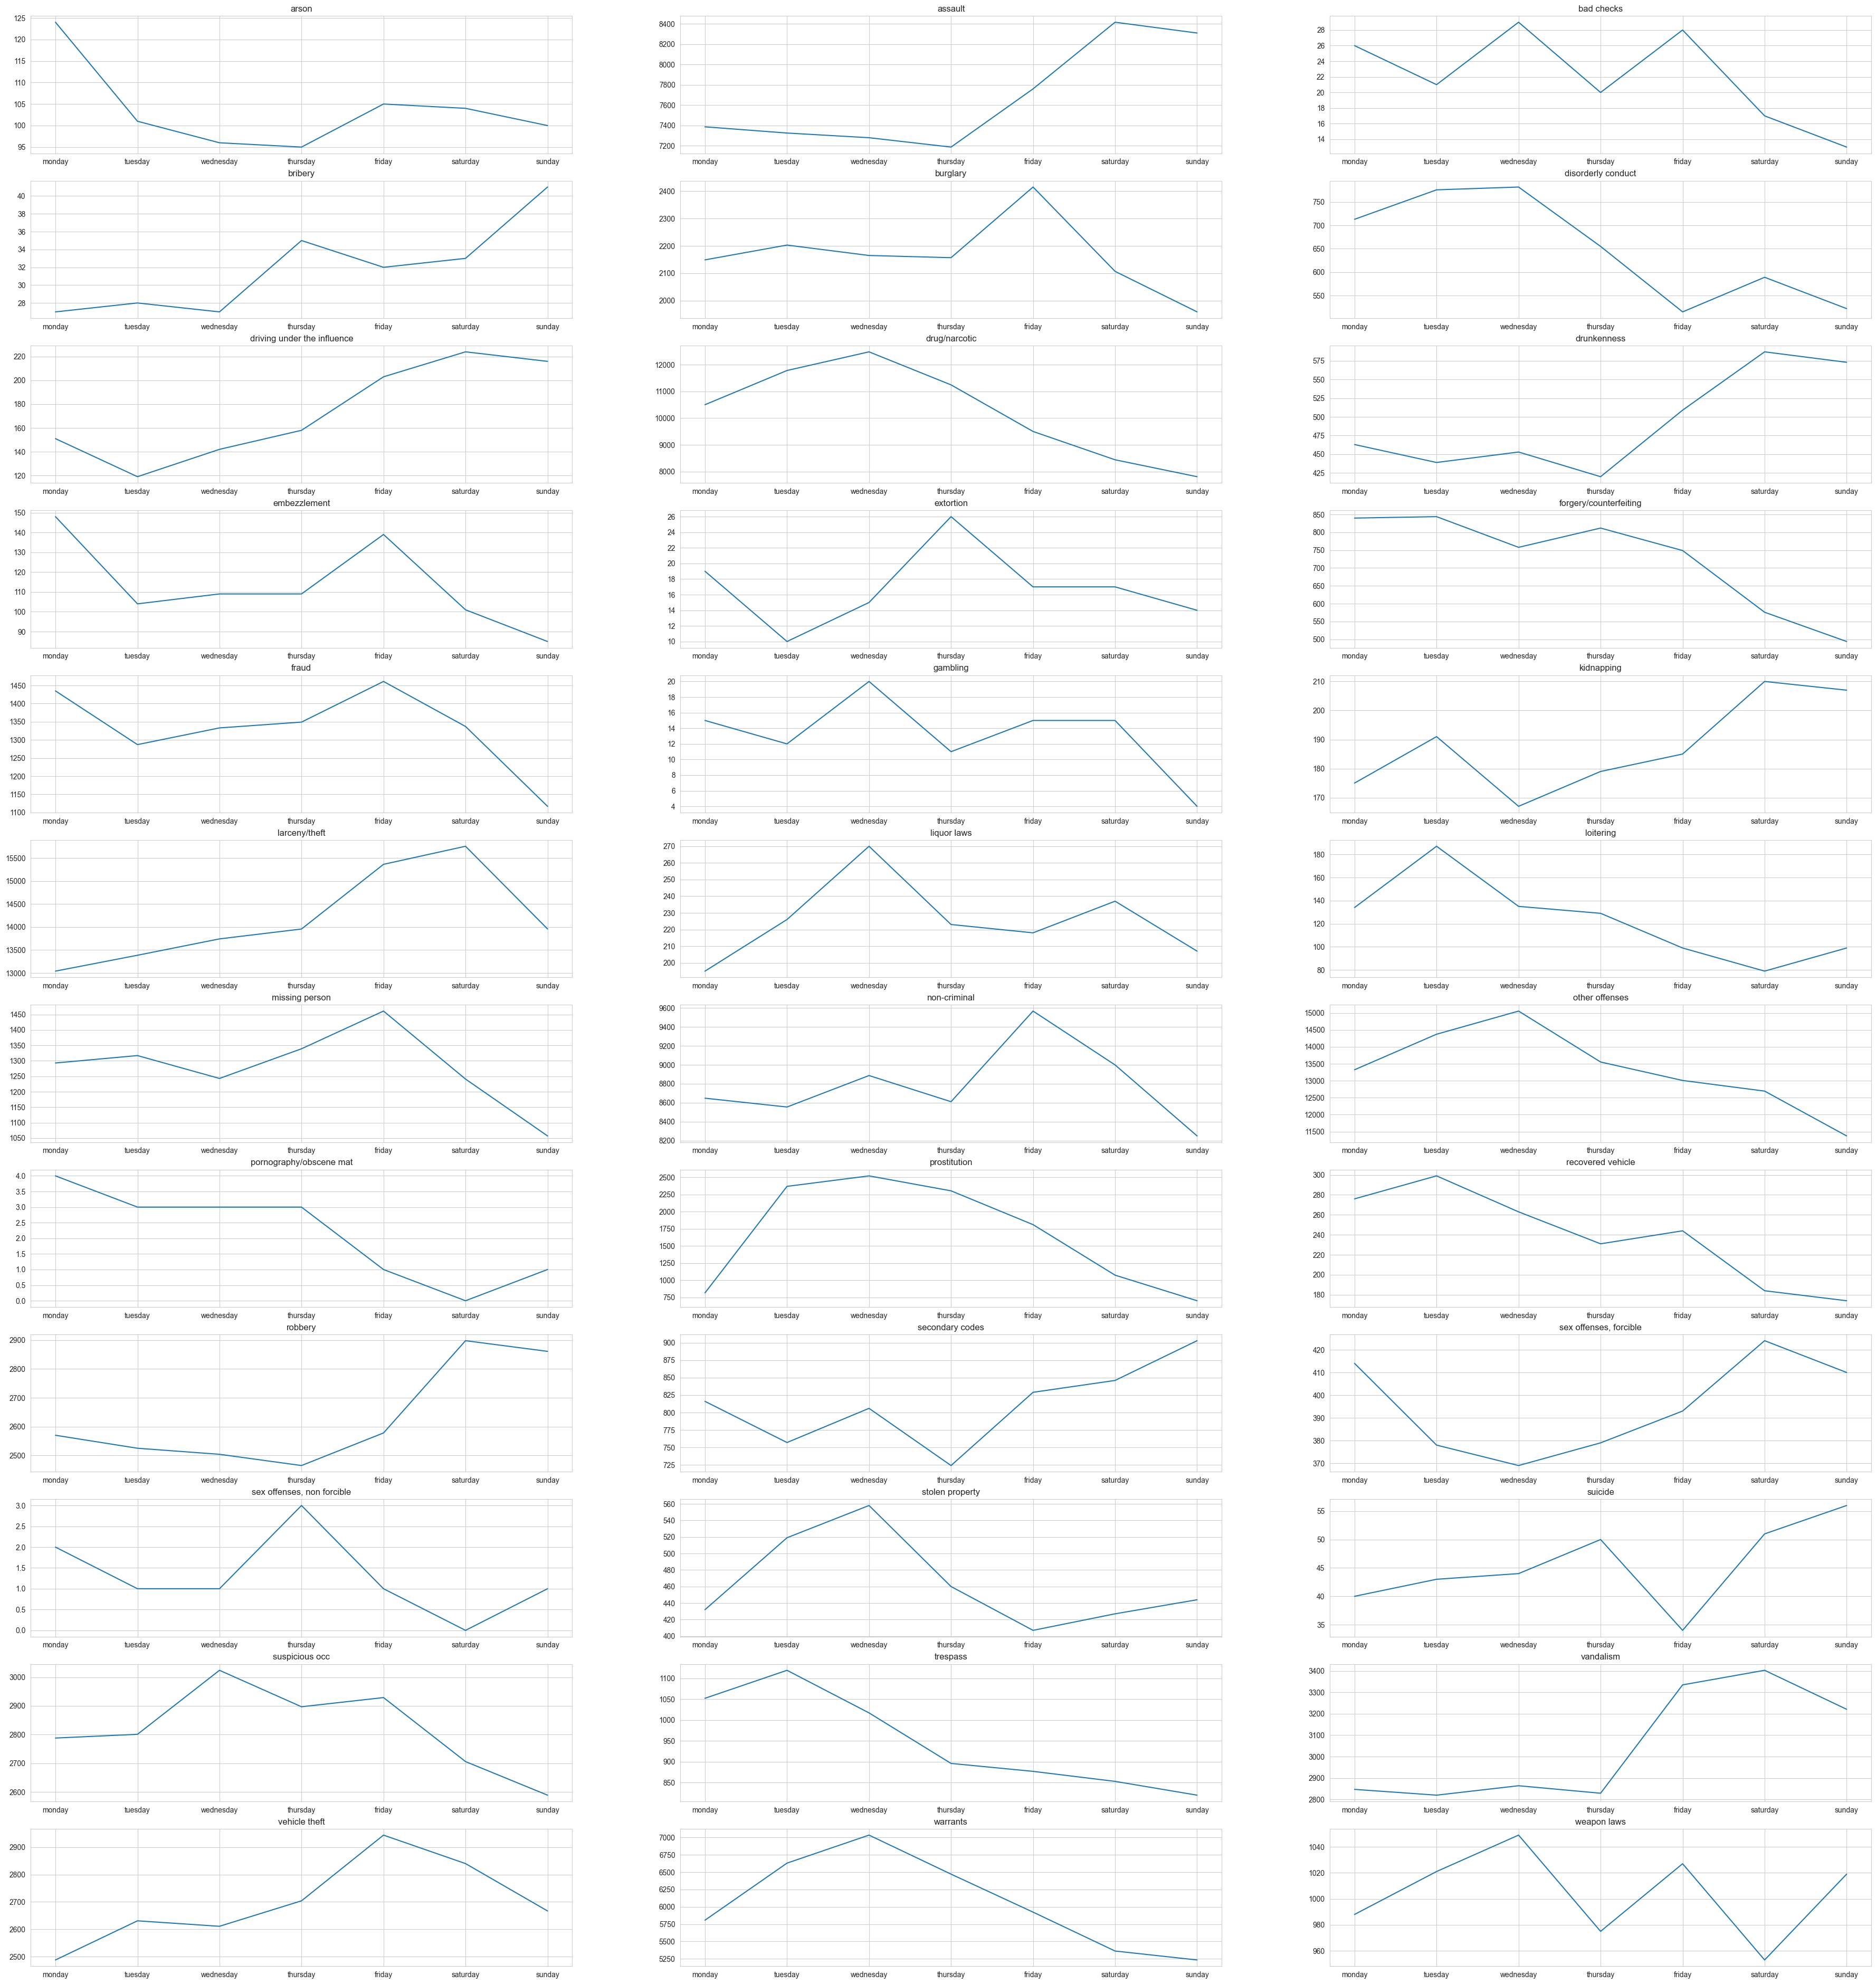

In [26]:
# Group by both category and weekday, then count the number of crimes
category_weekday = sf_combined.groupby(['category', 'weekday']).size().unstack(fill_value=0)

# Order the weekdays
order = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']
category_weekday = category_weekday[order]

# Set the aesthetics for the plot
sns.set_style('whitegrid')

# Determine the number of categories
num_categories = len(category_weekday.index)

# Set the number of columns for the subplot grid
num_cols = 3  # You can adjust this based on your preference and the number of categories
num_rows = np.ceil(num_categories / num_cols).astype(int)

# Create a subplot grid
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15 * num_cols, 4 * num_rows))

# Flatten the array of axes for easy iteration
axs = axs.flatten()

# Plotting each category in its own subplot
for i, category in enumerate(category_weekday.index):
    axs[i].plot(category_weekday.columns, category_weekday.loc[category], label=category)
    axs[i].set_title(category)

#plt.savefig('dag2.png', bbox_inches='tight')


### Top 5 crimes over weekdays for better overview

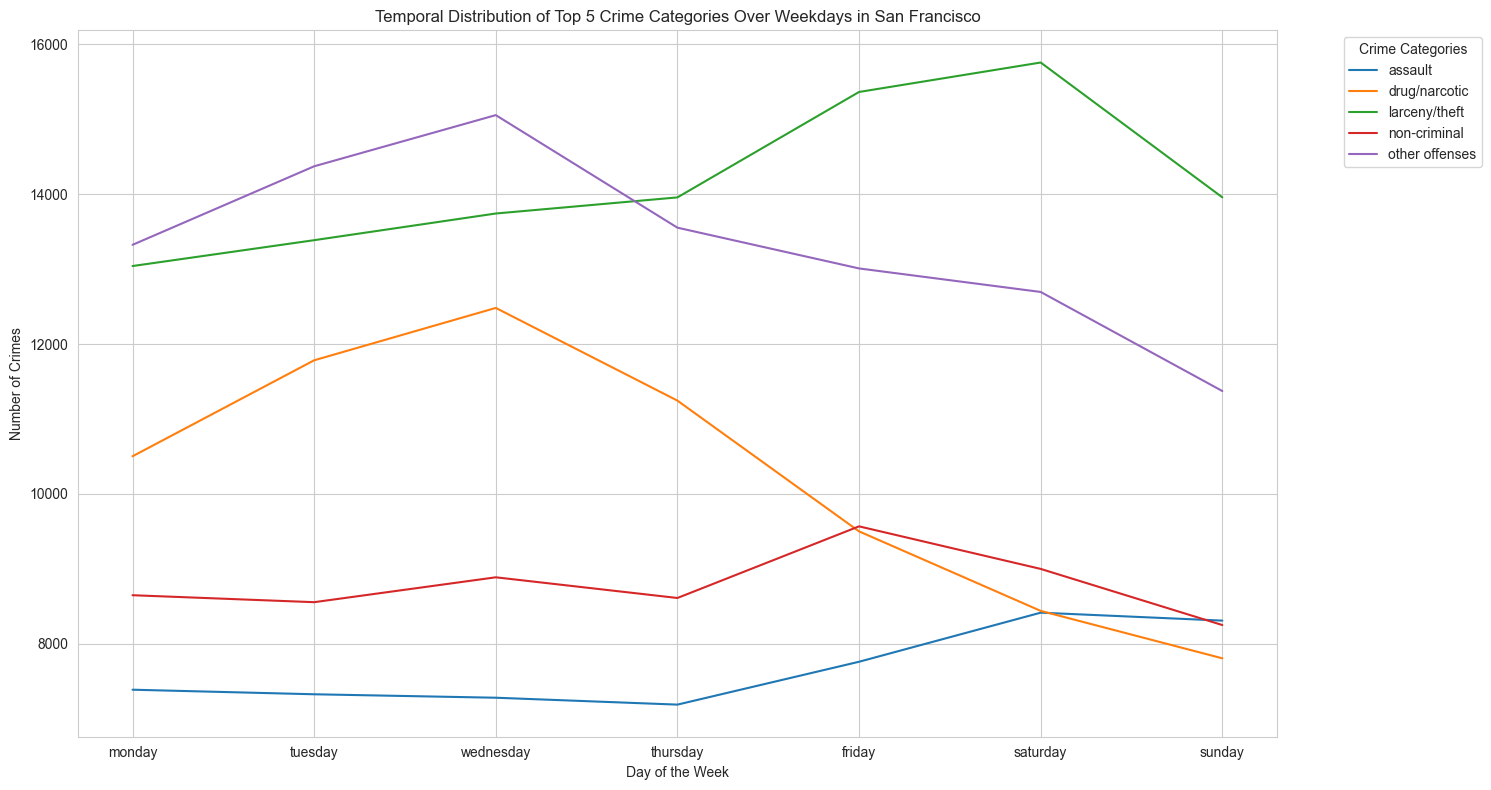

In [27]:
# Determine the top 5 crime categories
top_categories = sf_combined['category'].value_counts().nlargest(5).index

# Filter the data for the top 5 categories
top_crimes_data = sf_combined[sf_combined['category'].isin(top_categories)]

# Group by both category and weekday, then count the number of crimes
category_weekday = top_crimes_data.groupby(['category', 'weekday']).size().unstack(fill_value=0)

# Order the weekdays
category_weekday = category_weekday[order]

# Set the aesthetics for the plot
sns.set_style('whitegrid')
plt.figure(figsize=(15, 8))

# Plotting each category
for category in category_weekday.index:
    plt.plot(category_weekday.columns, category_weekday.loc[category], label=category)

plt.title('Temporal Distribution of Top 5 Crime Categories Over Weekdays in San Francisco')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Crimes')
plt.xticks(range(0, 7), order)
plt.legend(title='Crime Categories', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

#plt.savefig('dag3.png', bbox_inches='tight')
plt.show()


### Distribution of what the resolution of the crime was

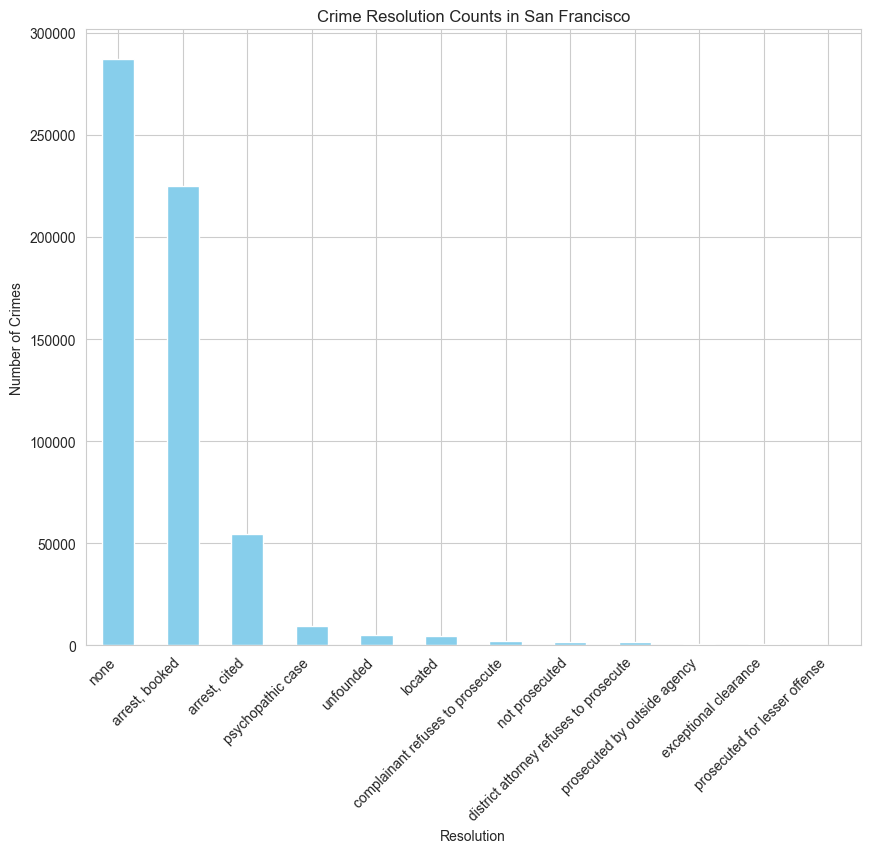

In [28]:
# plot the resolution of the crime

# Group by resolution and count the number of crimes
resolution_counts = sf_combined['resolution'].value_counts()

# Set the Seaborn style
sns.set_style('whitegrid')

# Basic plotting
plt.figure(figsize=(10, 8))
resolution_counts.plot(kind='bar', color='skyblue')

# Adding title and labels
plt.title("Crime Resolution Counts in San Francisco")
plt.xlabel("Resolution")
plt.ylabel("Number of Crimes")

# Adjust x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

#plt.savefig('resolution.png', bbox_inches='tight')

plt.show()


### Crime distribution based on year

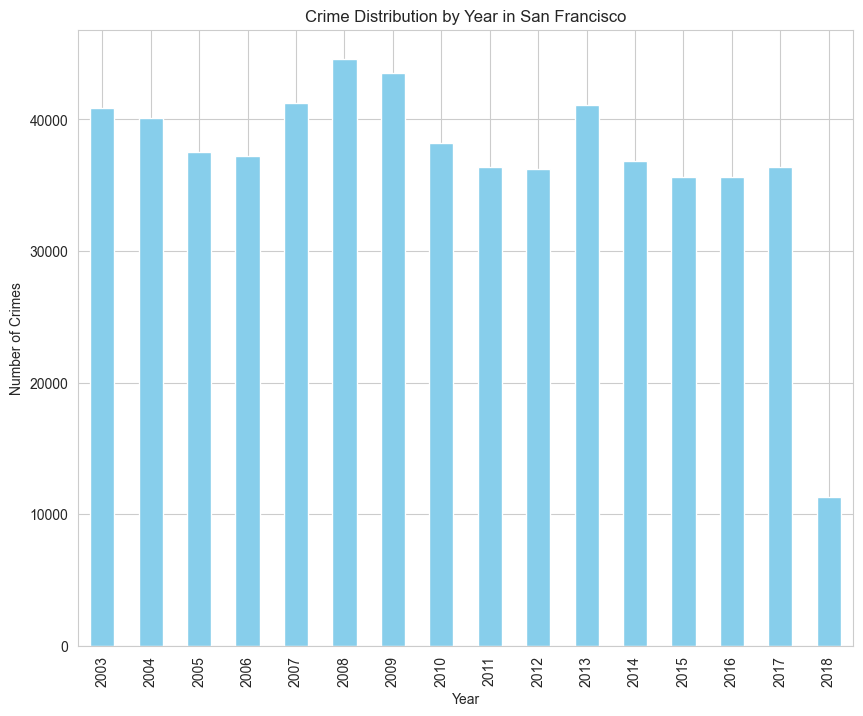

In [29]:
# crime distribution based on year
# Convert the 'date' column to datetime
sf_combined['date'] = pd.to_datetime(sf_combined['date'])

# Group by year and count the number of crimes
yearly_crime = sf_combined.groupby(sf_combined['date'].dt.year).size()

# Set the Seaborn style
sns.set_style('whitegrid')

# Basic plotting
plt.figure(figsize=(10, 8))
yearly_crime.plot(kind='bar', color='skyblue')

# Adding title and labels
plt.title("Crime Distribution by Year in San Francisco")
plt.xlabel("Year")
plt.ylabel("Number of Crimes")

#plt.savefig('year1.png', bbox_inches='tight')

plt.show()

In [42]:
sf_combined['date'].max()

Timestamp('2018-05-15 00:00:00')

The plot above represents crimes per year. It is essential to mention that the San Francisco Crime dataset only included crime records up to May 15, 2018, which is why the crime rate is low in 2018, but we are really just missing data.

### Crime distribution based on year (individual categories)

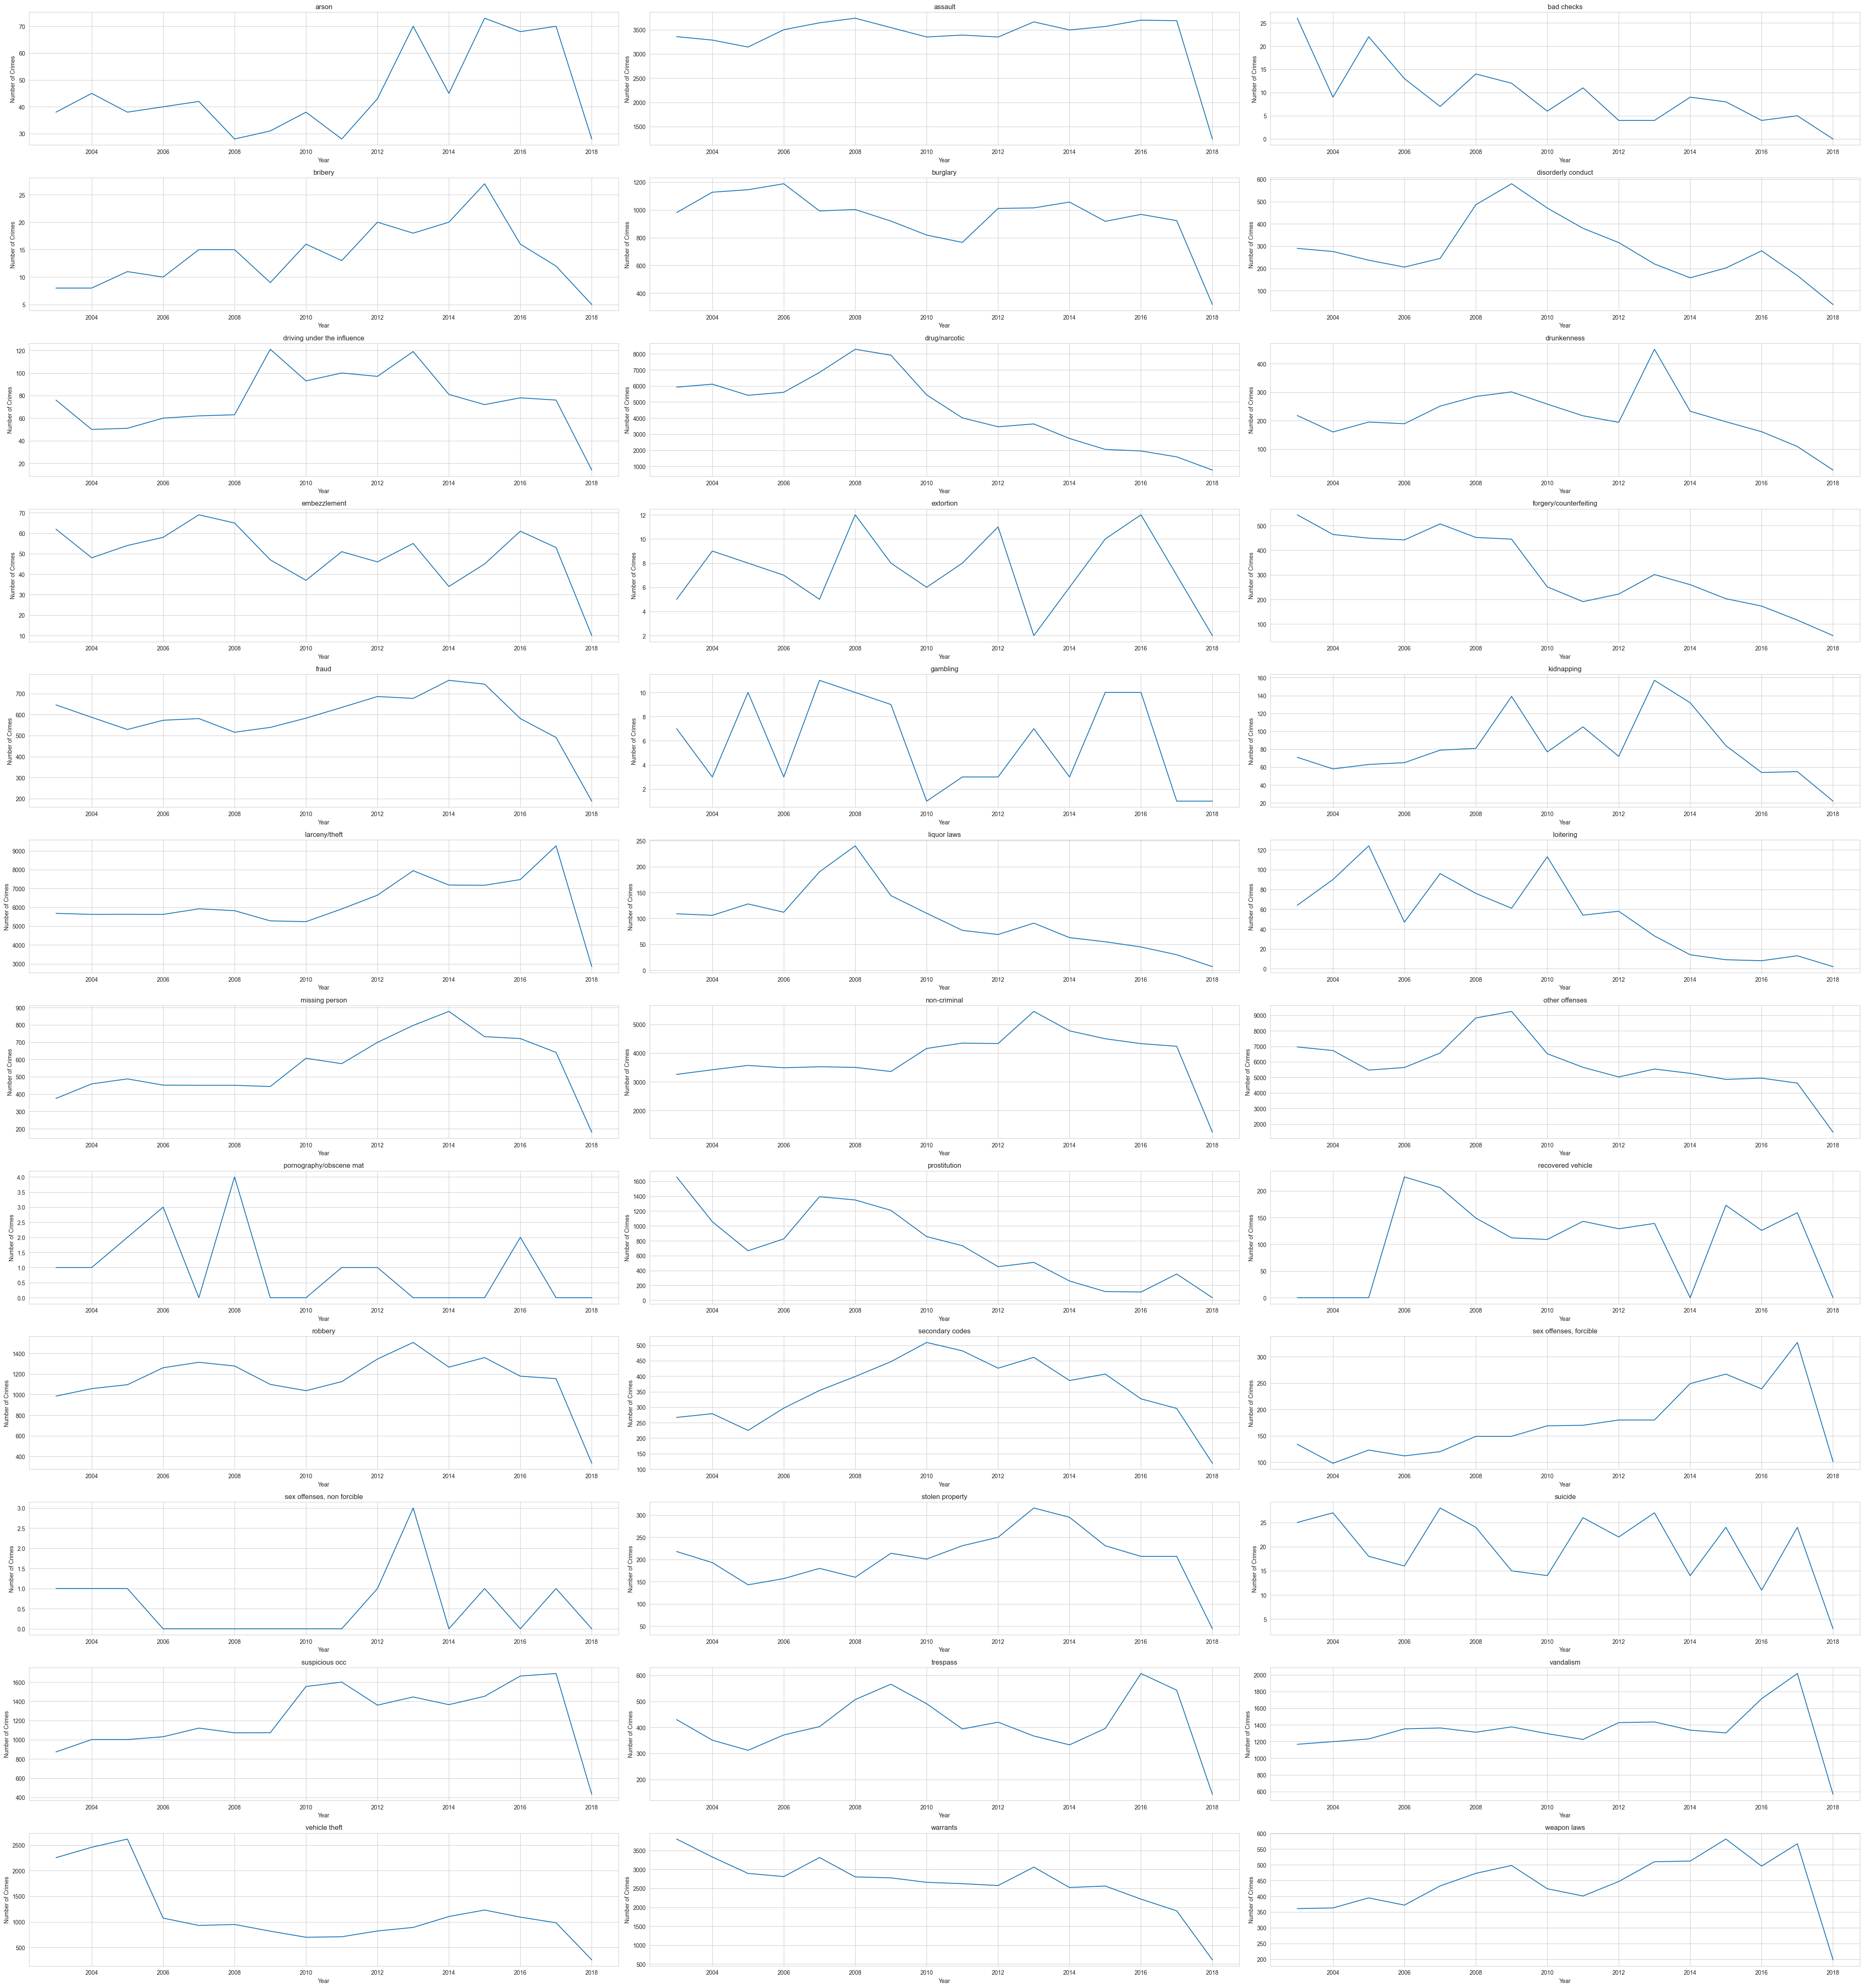

In [30]:
# crime distribution based on year and category
# Group by both category and year, then count the number of crimes
category_yearly = sf_combined.groupby(['category', sf_combined['date'].dt.year]).size().unstack(fill_value=0)

# Set the Seaborn style
sns.set_style('whitegrid')

# Determine the number of categories
num_categories = len(category_yearly.index)

# Set the number of columns for the subplot grid
num_cols = 3  # Adjust this based on your preference and the number of categories
num_rows = np.ceil(num_categories / num_cols).astype(int)

# Create a subplot grid
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15 * num_cols, 4 * num_rows))

# Flatten the array of axes for easy iteration
axs = axs.flatten()

# Plotting each category in its own subplot
for i, category in enumerate(category_yearly.index):
    axs[i].plot(category_yearly.columns, category_yearly.loc[category], label=category)
    axs[i].set_title(category)
    axs[i].set_xlabel('Year')
    axs[i].set_ylabel('Number of Crimes')

# Hide any unused subplots
for i in range(num_categories, len(axs)):
    axs[i].axis('off')

plt.tight_layout()
#plt.savefig('year2.png', bbox_inches='tight')

plt.show()


### Distribution of top 5 categories over years

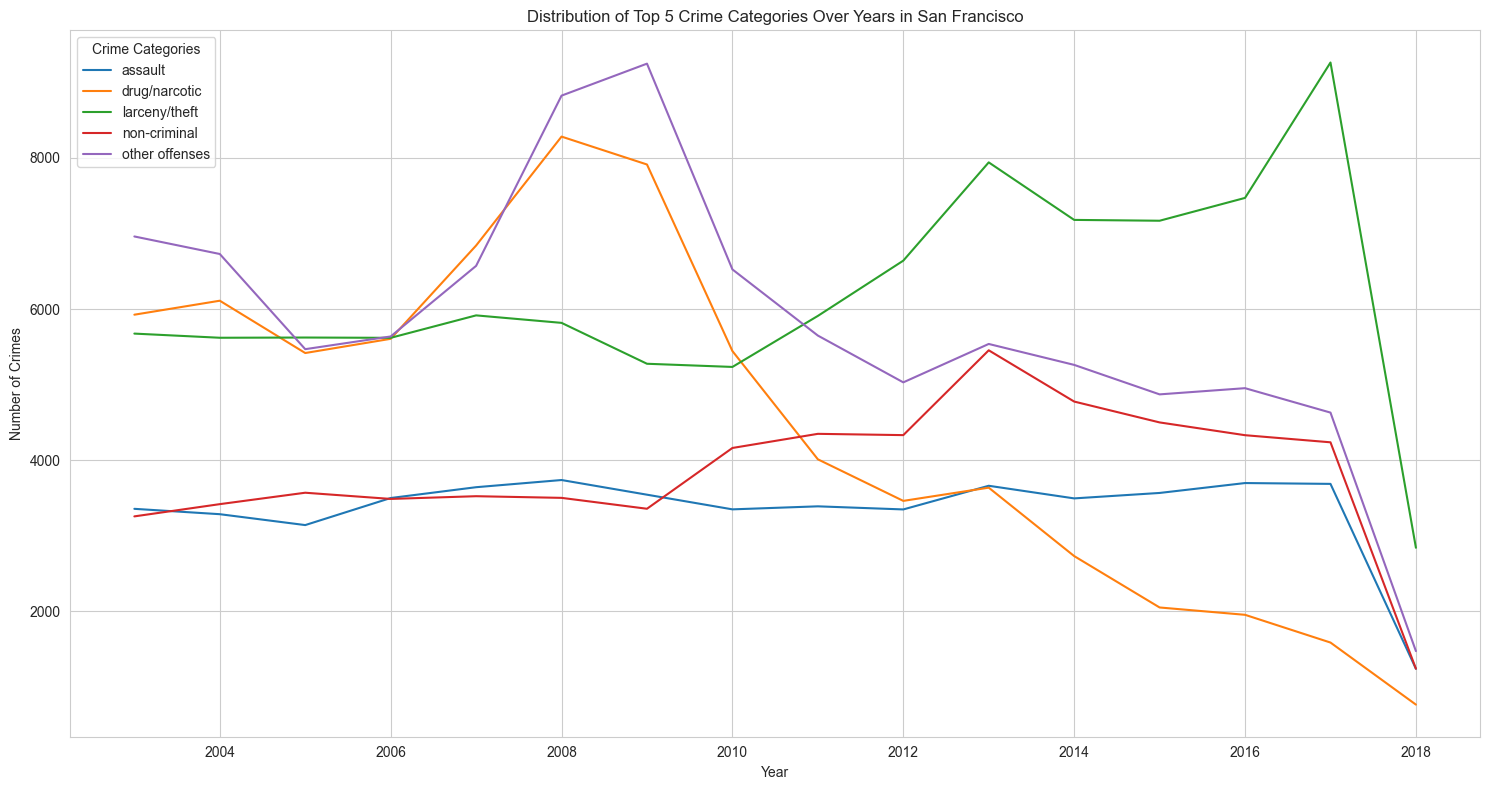

In [31]:
# crime distribution based on year and top 5 category in a single plot
# Determine the top 5 crime categories
top_categories = sf_combined['category'].value_counts().nlargest(5).index

# Filter the data for the top 5 categories
top_crimes_data = sf_combined[sf_combined['category'].isin(top_categories)]

# Group by both category and year, then count the number of crimes
category_yearly = top_crimes_data.groupby(['category', top_crimes_data['date'].dt.year]).size().unstack(fill_value=0)

# Set the Seaborn style
sns.set_style('whitegrid')
plt.figure(figsize=(15, 8))

# Plotting each category
for category in category_yearly.index:
    plt.plot(category_yearly.columns, category_yearly.loc[category], label=category)

plt.title('Distribution of Top 5 Crime Categories Over Years in San Francisco')

plt.xlabel('Year')
plt.ylabel('Number of Crimes')
plt.legend(title='Crime Categories')
plt.tight_layout()

#plt.savefig('year3.png', bbox_inches='tight')

plt.show()

In [32]:
sf_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 592854 entries, 0 to 592853
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   id           592854 non-null  int64         
 1   category     592854 non-null  object        
 2   description  592854 non-null  object        
 3   weekday      592854 non-null  object        
 4   date         592854 non-null  datetime64[ns]
 5   time         592854 non-null  object        
 6   resolution   592854 non-null  object        
 7   longitude    592854 non-null  float64       
 8   latitude     592854 non-null  float64       
 9   label        592854 non-null  object        
 10  district     592854 non-null  object        
 11  hour         592854 non-null  int32         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(1), object(7)
memory usage: 52.0+ MB


In [33]:
sf_combined.head()

id       category                   description    weekday  \
0  18023216504170        assault            false imprisonment   saturday   
1  17067335371000   non-criminal                 lost property  wednesday   
2  17083623864020   non-criminal  aided case, mental disturbed     friday   
3  18029886606243  larceny/theft  petty theft from locked auto     sunday   
4  16624968706372  larceny/theft       petty theft of property     sunday   

        date      time resolution   longitude   latitude    label    district  \
0 2018-03-24  07:00:00       none -122.419053  37.758632  violent     mission   
1 2017-07-19  12:00:00       none -122.419672  37.765050    other     mission   
2 2017-10-13  06:45:00       none -122.416894  37.784286    other  tenderloin   
3 2018-04-22  18:00:00       none -122.420691  37.781483    other  tenderloin   
4 2016-08-21  10:00:00       none -122.417885  37.785438    other  tenderloin   

   hour  
0     7  
1    12  
2     6  
3    18  
4    10

### Spatial analysis

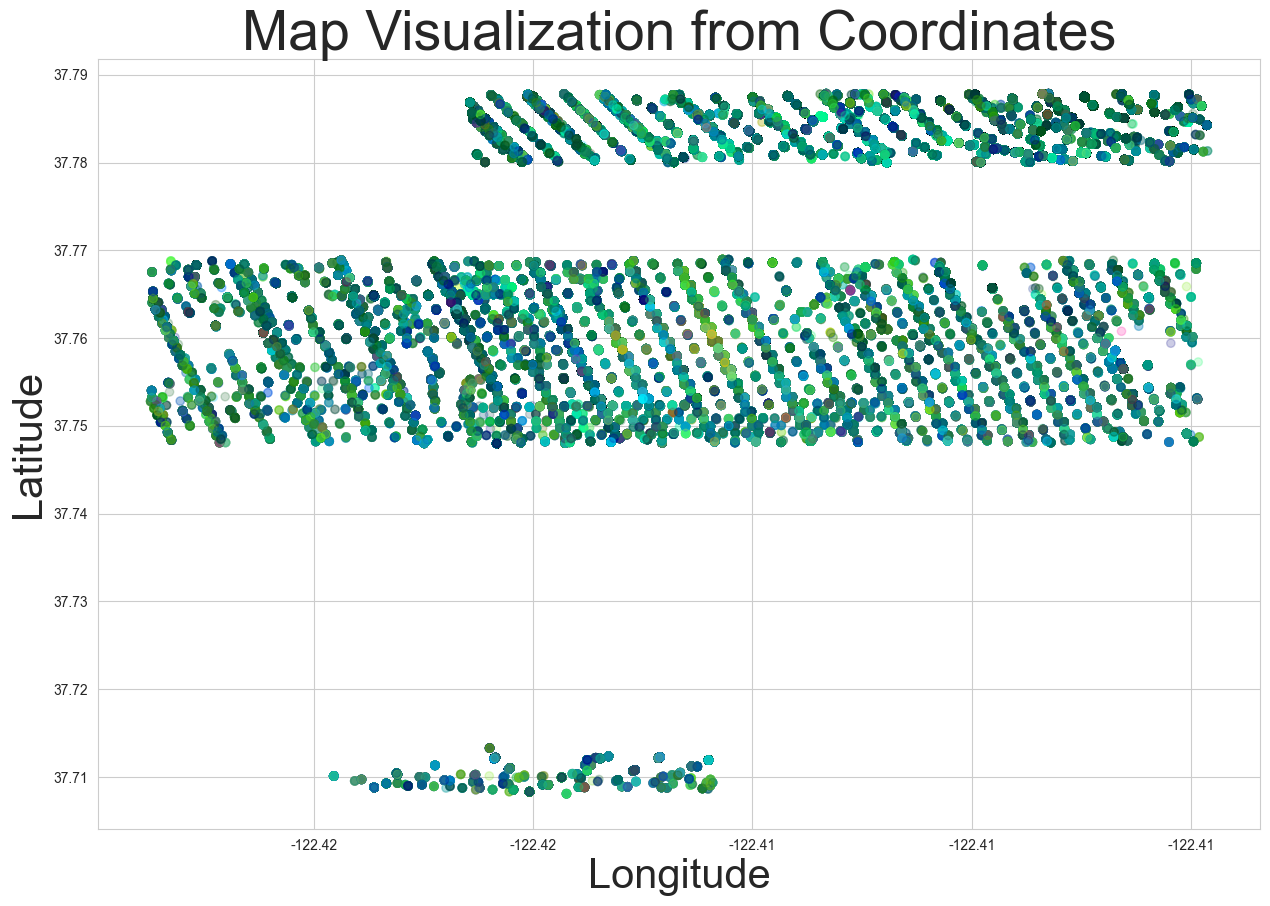

In [34]:
# Assign a color index to each category
color_map = dict(zip(sf_combined['category'].unique(), range(sf_combined['category'].nunique())))

# Draw a scatter plot to show the distribution
fig = plt.figure(figsize=(15, 10))

# Draw the scatter plot
plt.scatter(sf_combined['longitude'], sf_combined['latitude'], c=sf_combined['category'].map(color_map), cmap=plt.cm.gist_ncar, alpha=0.2)

plt.title("Map Visualization from Coordinates", fontsize=40)
plt.xlabel('Longitude', fontsize=30)
plt.ylabel('Latitude', fontsize=30)
# Set formatter for the x-axis
plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

#plt.savefig('spatial-analysis.png', bbox_inches='tight')

plt.show()

When plotting large datasets, points can overlap, especially if they are very close together geographically. This can make areas with high density of points appear to have fewer points because they are plotted over each other. So e.g. Tenderloin looks like it has less crimes than mission. Additionally, the Mission district is larger in geographical area than the Tenderloin.

North = Tenderloin,
Middle = Mission,
South = Sunnydale

In [35]:
# check all district and groupby
sf_combined['district'].value_counts()

district
tenderloin    345423
mission       234320
sunnydale      13111
Name: count, dtype: int64

In [36]:
# check tenderloin
sf_combined[sf_combined['latitude'] > 37.77].groupby('district').size()

district
tenderloin    345423
dtype: int64

In [37]:
# check mission
sf_combined[(sf_combined['latitude'] < 37.77) & (sf_combined['latitude'] > 37.74)].groupby('district').size()

district
mission    234320
dtype: int64

In [38]:
# check sunnydale
sf_combined[sf_combined['latitude'] < 37.72].groupby('district').size()

district
sunnydale    13111
dtype: int64

I ran into an "Out of Memory" when trying to plot all the datapoints with Plotly to show the crimes in the three district. So instead, I chose a subset of data. Otherwise, external tools and server-side rendering could have been an option.

In [39]:
import plotly.express as px

# Sample a fraction of the data
sampled_df = sf_combined.sample(frac=0.1) 

# Create the Plotly figure
fig = px.scatter_mapbox(sampled_df, lat="latitude", lon="longitude",
                        color="category", size_max=15, zoom=10,
                        mapbox_style="carto-positron")

# Save to HTML in your current folder
fig.write_html('reduced_plot.html')
